<a href="https://colab.research.google.com/github/zahran1234/EgyptionCompaniesReviews_Sentiment_analysis/blob/main/Sentiment_Analysis_features_extraction_from_word2vec100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import plotly.express as px
from scipy import stats
from sklearn.metrics import confusion_matrix,mean_squared_error,precision_score,recall_score,f1_score ,classification_report
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from gensim.models import Word2Vec
import tensorflow as tf

from tensorflow.keras.layers import Dense , SimpleRNN, Flatten ,Dropout, Input, Activation,GRU,LSTM,Conv1D

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re
from nltk.stem import ARLSTem
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from keras.utils import to_categorical



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
def get_accuracy(name, trained_model , x_train, y_train, x_test, y_test):
    tree_predict = trained_model.predict(x_test)
    print("Testing accuracy   :",metrics.accuracy_score(y_test, tree_predict)*100 , "%")
    print("MSE [TEST]          :",mean_squared_error(y_test, tree_predict))


    tree_predict1 = trained_model.predict(x_train)
    print("Training accuracy  :",metrics.accuracy_score(y_train, tree_predict1)*100 ,"%")
    print("MSE [TRAIN]         :",mean_squared_error(y_train, tree_predict1))

    print("precision : ",precision_score(y_test, tree_predict,average='micro'))
    print("recall    : ",recall_score(y_test, tree_predict,average='micro'))
    print("f1_score  : ",f1_score(y_test, tree_predict,average='micro'))


    cf1 = confusion_matrix(y_test,tree_predict)
    sns.heatmap(cf1,annot=True,fmt = '.0f')
    plt.xlabel('prediction')
    plt.ylabel('Actual')
    plt.title(name+ ' Confusion Matrix')
    plt.show()

    print(classification_report(y_train,  trained_model.predict(x_train)))
    print(classification_report(y_test,  trained_model.predict(x_test)))

In [3]:
def get_accuracy_NN(name, trained_model , x_train, y_train, x_test, y_test,y_train_enc,y_test_enc):
  loss,acc=model.evaluate(x_test,y_test_enc)
  print("test loss :", loss)
  print('test accuracy:',acc*100)
  print("____________________________")
  loss,acc=model.evaluate(x_train,y_train_enc)
  print("trainig loss :", loss)
  print('trainig accuracy:',acc*100)
  print("____________________________")

  pred=model.predict(x_test)
  pred_list=[]
  for i in pred:
    pred_list.append(np.argmax(i))
  cf1 = confusion_matrix(y_test,pred_list)
  sns.heatmap(cf1,annot=True,fmt = '.0f')
  plt.xlabel('prediction')
  plt.ylabel('Actual')
  plt.title(name+ ' Confusion Matrix')
  plt.show()
  print("true")
  print(classification_report(y_test,pred_list  ))
  

In [4]:
df= pd.read_excel('/content/original_dataset.xlsx')

In [5]:
df=pd.DataFrame(df)

In [6]:
df.head()

,Unnamed: 0,review_description,rating,company
0,0,سيئ جدا بعد الإصدار الجديد,-1,alahli_bank
1,1,ابلكيشن زباله بجد,-1,alahli_bank
2,2,سيئ التطبيق لايعمل,-1,alahli_bank
3,3,للأسف التطبيق للأسوأ كان جدا رائع وسهل وبسيط ا...,-1,alahli_bank
4,4,التحديث بطيئ جدا جدا عند الفتح,-1,alahli_bank


In [7]:
print(df.shape)
df=df.dropna()
df=df.drop_duplicates()
print(df.shape)

(67127, 4)
(67125, 4)


# **data visualization**

<AxesSubplot:>

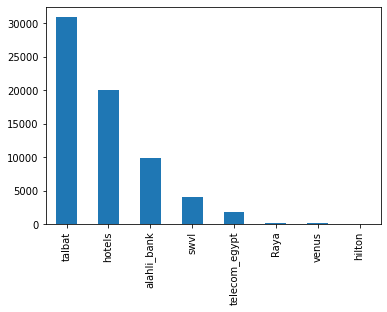

In [8]:
df.company.value_counts().plot(kind='bar')

In [9]:
fig = px.sunburst(df, path=['rating'],title= ' rating')
fig.update_traces(textinfo='label + percent parent')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='rating', ylabel='count'>

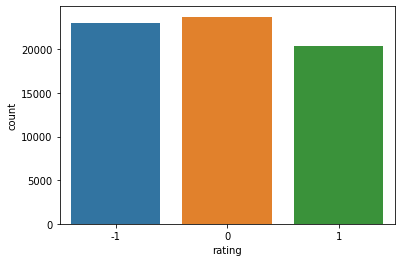

In [10]:
sns.countplot(df.rating)

In [11]:
fig = px.sunburst(df, path=['company', 'rating'],title= 'Relation between company and rating')
fig.update_traces(textinfo='label + percent parent')

In [12]:
emojis = {
    "🙂":"يبتسم",
    "😂":"يضحك",
    "💔":"قلب حزين",
    "🙂":"يبتسم",
    "❤️":"حب",
    "❤":"حب",
    "😍":"حب",
    "😭":"يبكي",
    "😢":"حزن",
    "😔":"حزن",
    "♥":"حب",
    "💜":"حب",
    "😅":"يضحك",
    "🙁":"حزين",
    "💕":"حب",
    "💙":"حب",
    "😞":"حزين",
    "😊":"سعادة",
    "👏":"يصفق",
    "👌":"احسنت",
    "😴":"ينام",
    "😀":"يضحك",
    "😌":"حزين",
    "🌹":"وردة",
    "🙈":"حب",
    "😄":"يضحك",
    "😐":"محايد",
    "✌":"منتصر",
    "✨":"نجمه",
    "🤔":"تفكير",
    "😏":"يستهزء",
    "😒":"يستهزء",
    "🙄":"ملل",
    "😕":"عصبية",
    "😃":"يضحك",
    "🌸":"وردة",
    "😓":"حزن",
    "💞":"حب",
    "💗":"حب",
    "😑":"منزعج",
    "💭":"تفكير",
    "😎":"ثقة",
    "💛":"حب",
    "😩":"حزين",
    "💪":"عضلات",
    "👍":"موافق",
    "🙏🏻":"رجاء طلب",
    "😳":"مصدوم",
    "👏🏼":"تصفيق",
    "🎶":"موسيقي",
    "🌚":"صمت",
    "💚":"حب",
    "🙏":"رجاء طلب",
    "💘":"حب",
    "🍃":"سلام",
    "☺":"يضحك",
    "🐸":"ضفدع",
    "😶":"مصدوم",
    "✌️":"مرح",
    "✋🏻":"توقف",
    "😉":"غمزة",
    "🌷":"حب",
    "🙃":"مبتسم",
    "😫":"حزين",
    "😨":"مصدوم",
    "🎼 ":"موسيقي",
    "🍁":"مرح",
    "🍂":"مرح",
    "💟":"حب",
    "😪":"حزن",
    "😆":"يضحك",
    "😣":"استياء",
    "☺️":"حب",
    "😱":"كارثة",
    "😁":"يضحك",
    "😖":"استياء",
    "🏃🏼":"يجري",
    "😡":"غضب",
    "🚶":"يسير",
    "🤕":"مرض",
    "‼️":"تعجب",
    "🕊":"طائر",
    "👌🏻":"احسنت",
    "❣":"حب",
    "🙊":"مصدوم",
    "💃":"سعادة مرح",
    "💃🏼":"سعادة مرح",
    "😜":"مرح",
    "👊":"ضربة",
    "😟":"استياء",
    "💖":"حب",
    "😥":"حزن",
    "🎻":"موسيقي",
    "✒":"يكتب",
    "🚶🏻":"يسير",
    "💎":"الماظ",
    "😷":"وباء مرض",
    "☝":"واحد",
    "🚬":"تدخين",
    "💐" : "ورد",
    "🌞" : "شمس",
    "👆" : "الاول",
    "⚠️" :"تحذير",
    "🤗" : "احتواء",
    "✖️": "غلط",
    "📍"  : "مكان",
    "👸" : "ملكه",
    "👑" : "تاج",
    "✔️" : "صح",
    "💌": "قلب",
    "😲" : "مندهش",
    "💦": "ماء",
    "🚫" : "خطا",
    "👏🏻" : "برافو",
    "🏊" :"يسبح",
    "👍🏻": "تمام",
    "⭕️" :"دائره كبيره",
    "🎷" : "ساكسفون",
    "👋": "تلويح باليد",
    "✌🏼": "علامه النصر",
    "🌝":"مبتسم",
    "➿"  : "عقده مزدوجه",
    "💪🏼" : "قوي",
    "📩":  "تواصل معي",
    "☕️": "قهوه",
    "😧" : "قلق و صدمة",
    "🗨": "رسالة",   
    "❗️" :"تعجب",
    "🙆🏻": "اشاره موافقه",
    "👯" :"اخوات",
    "©" :  "رمز",
    "👵🏽" :"سيده عجوزه",
    "🐣": "كتكوت",  
    "🙌": "تشجيع",
    "🙇": "شخص ينحني",
    "👐🏽":"ايدي مفتوحه",    
    "👌🏽": "بالظبط",
    "⁉️" : "استنكار",
    "⚽️": "كوره",
    "🕶" :"حب",
    "🎈" :"بالون",    
    "🎀":    "ورده",
    "💵":  "فلوس",   
    "😋":  "جائع",
    "😛":  "يغيظ",
    "😠":  "غاضب",
    "✍🏻":  "يكتب",
    "🌾":  "ارز",
    "👣":  "اثر قدمين",
    "❌":"رفض",
    "🍟":"طعام",
    "👬":"صداقة",
    "🐰":"ارنب",
    "☂":"مطر",
    "⚜":"مملكة فرنسا",
    "🐑":"خروف",
    "🗣":"صوت مرتفع",
    "👌🏼":"احسنت",
    "☘":"مرح",
    "😮":"صدمة",
    "😦":"قلق",
    "⭕":"الحق",
    "✏️":"قلم",
    "ℹ":"معلومات",
    "🙍🏻":"رفض",
    "⚪️":"نضارة نقاء",
    "🐤":"حزن",
    "💫":"مرح",
    "💝":"حب",
    "🍔":"طعام",
    "❤︎":"حب",
    "✈️":"سفر",
    "🏃🏻‍♀️":"يسير",
    "🍳":"ذكر",
    "🎤":"مايك غناء",
    "🎾":"كره",
    "🐔":"دجاجة",
    "🙋":"سؤال",
    "📮":"بحر",
    "💉":"دواء",
    "🙏🏼":"رجاء طلب",
    "💂🏿 ":"حارس",
    "🎬":"سينما",
    "♦️":"مرح",
    "💡":"قكرة",
    "‼":"تعجب",
    "👼":"طفل",
    "🔑":"مفتاح",
    "♥️":"حب",
    "🕋":"كعبة",
    "🐓":"دجاجة",
    "💩":"معترض",
    "👽":"فضائي",
    "☔️":"مطر",
    "🍷":"عصير",
    "🌟":"نجمة",
    "☁️":"سحب",
    "👃":"معترض",
    "🌺":"مرح",
    "🔪":"سكينة",
    "♨":"سخونية",
    "👊🏼":"ضرب",
    "✏":"قلم",
    "🚶🏾‍♀️":"يسير",
    "👊":"ضربة",
    "◾️":"وقف",
    "😚":"حب",
    "🔸":"مرح",
    "👎🏻":"لا يعجبني",
    "👊🏽":"ضربة",
    "😙":"حب",
    "🎥":"تصوير",
    "👉":"جذب انتباه",
    "👏🏽":"يصفق",
    "💪🏻":"عضلات",
    "🏴":"اسود",
    "🔥":"حريق",  
    "😬":"عدم الراحة",   
    "👊🏿":"يضرب",    
    "🌿":"ورقه شجره",     
    "✋🏼":"كف ايد",    
    "👐":"ايدي مفتوحه",      
    "☠️":"وجه مرعب",     
    "🎉":"يهنئ",      
    "🔕" :"صامت",
    "😿":"وجه حزين",      
    "☹️":"وجه يائس",     
    "😘" :"حب",     
    "😰" :"خوف و حزن",
    "🌼":"ورده",      
    "💋":  "بوسه",
    "👇":"لاسفل",     
    "❣️":"حب",     
    "🎧":"سماعات",
    "📝":"يكتب",      
    "😇":"دايخ",      
    "😈":"رعب",      
    "🏃":"يجري",      
    "✌🏻":"علامه النصر",    
    "🔫":"يضرب",      
    "❗️":"تعجب",
    "👎":"غير موافق",      
    "🔐":"قفل",      
    "👈":"لليمين",
    "™":"رمز",    
    "🚶🏽":"يتمشي",    
    "😯":"متفاجأ",  
    "✊":"يد مغلقه",    
    "😻":"اعجاب",    
    "🙉" :"قرد",    
    "👧":"طفله صغيره",     
    "🔴":"دائره حمراء",      
    "💪🏽":"قوه",     
    "💤":"ينام",     
    "👀":"ينظر",     
    "✍🏻":"يكتب",  
    "❄️":"تلج",
    "💀":"رعب",   
    "😤":"وجه عابس",      
    "🖋":"قلم",      
    "🎩":"كاب",      
    "☕️":"قهوه",     
    "😹":"ضحك",     
    "💓":"حب",      
    "☄️ ":"نار",     
    "👻":"رعب",
    "❎":"خطء",
    "🤮":"حزن",
    '🏻':"احمر"
    }

emoticons_to_emoji = {
    ":)" : "🙂",
    ":(" : "🙁",
    "xD" : "😆",
    ":=(": "😭",
    ":'(": "😢",
    ":'‑(": "😢",
    "XD" : "😂",
    ":D" : "🙂",
    "♬" : "موسيقي",
    "♡" : "❤",
    "☻"  : "🙂",
    }

# **data cleaning**

In [13]:
def del_digits_and_pun(value,pun):
    new_value= re.sub('[1-9]','',value)
    for i in pun:
        new_value=new_value.replace(i,' ')
    return new_value

In [14]:
def tokens_review(x,stop_words):
    x=str(x)
    words=word_tokenize(x)
    new_words=[]
    for i in words:
        text = re.sub(r'[^ء-ي ]',' ',i)
        
        if text not in stop_words:
            new_words.append(text)
    return new_words

In [15]:
def remove_diacritics(text):
        arabic_diacritics = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
        text = re.sub(arabic_diacritics, '', str(text))
        return text 

In [16]:
def hendle_emojis(text,emojis):
  li=[]
  for i in word_tokenize(text):
    for x in i :
      if x not in emojis.keys():
        li.append(i)
        break
      else:
        li.append(emojis[x])
  return " ".join(li)
        

delete english punctuations and arabic punctuations from our reviews

In [17]:
hendle_emojis("😂😂😂", emojis)

'يضحك يضحك يضحك'

In [18]:
arabic_punctuations = """
`÷×؛،.<>_()*&^%][ـ،/:؟.,'{}~¦+|!”…“–#.ـ
"""

english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations
punctuations_list
list_pun=[i for i in punctuations_list]


df.review_description=df.review_description.apply(del_digits_and_pun,args=[list_pun])



# ** staming  reviwe**

In [19]:
def preprossing (review):
  words=word_tokenize(review)
  new_words=[]
  stop_words=stopwords.words('arabic')
  stop_words.remove('لا')
  stop_words.remove('لكن')
  stop_words.remove('ولكن')
  stop_words.remove('واو')
  stop_words.remove('أطعم')
  stop_words.remove('أف')
  stop_words.append('طلبات')
  stop_words.append('شركه')
  stop_words.append('برنامج')
  stop_words.append('تطبيق')
  for i in words:
    stemmer = ARLSTem()
    word = stemmer.stem(i)
    if i in stop_words:
      continue 
    new_words.append(word)

  return " ".join(new_words)




In [20]:
import nltk

df['clean']=df.review_description.apply(preprossing)
df['clean']=df.clean.apply(hendle_emojis,args=[emojis])



In [21]:
df.head()

,Unnamed: 0,review_description,rating,company,clean
0,0,سيئ جدا بعد الإصدار الجديد,-1,alahli_bank,سيئ جدا صدر جديد
1,1,ابلكيشن زباله بجد,-1,alahli_bank,بلكيش زبال بجد
2,2,سيئ التطبيق لايعمل,-1,alahli_bank,سيئ تطبيق لايعمل
3,3,للأسف التطبيق للأسوأ كان جدا رائع وسهل وبسيط ا...,-1,alahli_bank,اسف تطبيق اسوا جدا رائع سهل بسيط معقد فتح معا ...
4,4,التحديث بطيئ جدا جدا عند الفتح,-1,alahli_bank,تحديث بطيئ جدا جدا فتح


In [22]:
x=df['clean'].tolist()
x[:10]

['سيئ جدا صدر جديد',
 'بلكيش زبال بجد',
 'سيئ تطبيق لايعمل',
 'اسف تطبيق اسوا جدا رائع سهل بسيط معقد فتح معا بسهول تجد خدم متاح',
 'تحديث بطيئ جدا جدا فتح',
 'مرررر زق اخر حديث فتحلي ابد رفض اي كلم مرور كتب او رقم بطاق اهلي خربت غلب ناس كان معتمد اسف',
 'تطبيق شتغل عمل سجيل دخول حسابي فتح شوفو حل انا معطل',
 'اذا قمت بفتح تطبيق طلب حديث اذا ضغط تحديث قبل تحديث لاهو للي فتح لاهو للي حدث وش مشكل',
 'اسف سيئ جدا امس احول ستخدم مافي اتواصل خدم عملاء قال حذف نزل جديد يمك يكو حديث نفس مشكل ماانحل',
 'صراح شي موسف']

In [23]:
tfidfconverter= TfidfVectorizer(max_features=1000,ngram_range=(1,3))
X_Vec = tfidfconverter.fit_transform(x)
X_Vec = pd.DataFrame.sparse.from_spmatrix(X_Vec)
Y=df["rating"]


# **split dataset**

In [24]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X_Vec,Y,random_state=42,test_size=0.02,shuffle=True)


Testing accuracy   : 86.15040953090097 %
MSE [TEST]          : 0.33730454206999255
Training accuracy  : 85.6860539357271 %
MSE [TRAIN]         : 0.3402906570186373
precision :  0.8615040953090097
recall    :  0.8615040953090097
f1_score  :  0.8615040953090097


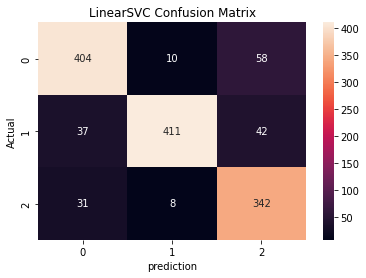

              precision    recall  f1-score   support

          -1       0.86      0.86      0.86     22563
           0       0.95      0.82      0.88     23261
           1       0.78      0.89      0.83     19958

    accuracy                           0.86     65782
   macro avg       0.86      0.86      0.86     65782
weighted avg       0.86      0.86      0.86     65782

              precision    recall  f1-score   support

          -1       0.86      0.86      0.86       472
           0       0.96      0.84      0.89       490
           1       0.77      0.90      0.83       381

    accuracy                           0.86      1343
   macro avg       0.86      0.86      0.86      1343
weighted avg       0.87      0.86      0.86      1343



In [25]:

from sklearn.svm import LinearSVC
trained_clf_svc = LinearSVC().fit(x_train, y_train)
get_accuracy('LinearSVC',trained_clf_svc,x_train, y_train, x_test, y_test)


# **features extraction  word2vec**

In [26]:
from gensim.models import Word2Vec
sents=[]
dim_num=100
for i in df.clean:
  sents.append(word_tokenize(i))
model=Word2Vec(sentences=sents, window=5, min_count=1, workers=4,size=dim_num)


In [27]:
X=np.zeros((dim_num,), dtype=float)

for i in (df.clean):
  counter=0
  sum=np.zeros((100,), dtype=float)
  for x in word_tokenize(i) :
    sum+=model.wv[x]
    counter+=1
  if counter==0 :
    X=np.vstack((X,sum))
  else:
    X=np.vstack((X,sum/counter))
X= np.delete(X, (0), axis=0)
y=df.rating 
X.shape

  

(67125, 100)

**# get X and y**

In [28]:
from sklearn.model_selection import train_test_split

def encod(x):
  if x==-1:
    return 0
  if x== 0:
    return 1
  return 2
y=df.rating
y=y.apply(encod)
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=.02,shuffle=True)
y_train_enc = tf.keras.utils.to_categorical(y_train)
y_test_enc=tf.keras.utils.to_categorical(y_test)


# **LinearSVC**

In [29]:

from sklearn.svm import LinearSVC
trained_clf_svc = LinearSVC().fit(x_train, y_train)


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Testing accuracy   : 81.23603871928519 %
MSE [TEST]          : 0.3864482501861504
Training accuracy  : 81.47213523456264 %
MSE [TRAIN]         : 0.3727615457115928
precision :  0.8123603871928519
recall    :  0.8123603871928519
f1_score  :  0.8123603871928519


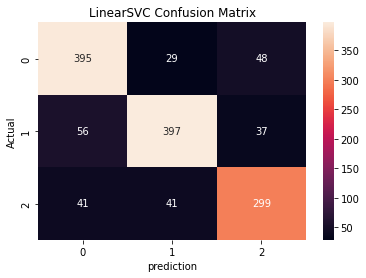

              precision    recall  f1-score   support

           0       0.81      0.84      0.83     22563
           1       0.84      0.80      0.82     23261
           2       0.79      0.80      0.79     19958

    accuracy                           0.81     65782
   macro avg       0.81      0.81      0.81     65782
weighted avg       0.82      0.81      0.81     65782

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       472
           1       0.85      0.81      0.83       490
           2       0.78      0.78      0.78       381

    accuracy                           0.81      1343
   macro avg       0.81      0.81      0.81      1343
weighted avg       0.81      0.81      0.81      1343



In [30]:
get_accuracy('LinearSVC',trained_clf_svc,x_train, y_train, x_test, y_test)

# **apply decision tree model**

Testing accuracy   : 77.28965003723009 %
MSE [TEST]          : 0.5241995532390171
Training accuracy  : 77.772034903165 %
MSE [TRAIN]         : 0.5125566264327628
precision :  0.7728965003723008
recall    :  0.7728965003723008
f1_score  :  0.772896500372301


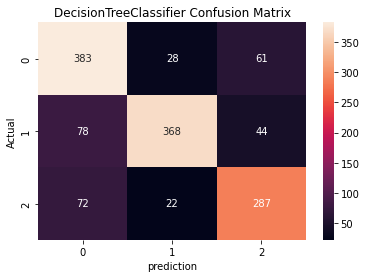

              precision    recall  f1-score   support

           0       0.72      0.84      0.78     22563
           1       0.90      0.73      0.80     23261
           2       0.74      0.77      0.75     19958

    accuracy                           0.78     65782
   macro avg       0.79      0.78      0.78     65782
weighted avg       0.79      0.78      0.78     65782

              precision    recall  f1-score   support

           0       0.72      0.81      0.76       472
           1       0.88      0.75      0.81       490
           2       0.73      0.75      0.74       381

    accuracy                           0.77      1343
   macro avg       0.78      0.77      0.77      1343
weighted avg       0.78      0.77      0.77      1343



In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3,5,10,15,20,None],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
}

clf = DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, min_samples_split= 2).fit(x_train,y_train)
get_accuracy('DecisionTreeClassifier',clf,x_train, y_train, x_test, y_test)


# **random forest model**

Testing accuracy   : 83.469843633656 %
MSE [TEST]          : 0.3819806403574088
Training accuracy  : 84.71162324040012 %
MSE [TRAIN]         : 0.34570247180079655
precision :  0.8346984363365599
recall    :  0.8346984363365599
f1_score  :  0.8346984363365598


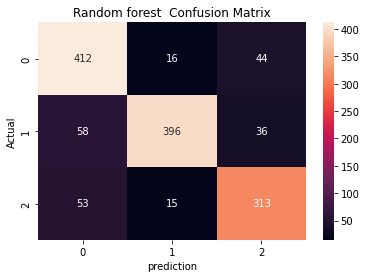

              precision    recall  f1-score   support

           0       0.81      0.89      0.85     22563
           1       0.93      0.81      0.87     23261
           2       0.81      0.84      0.82     19958

    accuracy                           0.85     65782
   macro avg       0.85      0.85      0.85     65782
weighted avg       0.85      0.85      0.85     65782

              precision    recall  f1-score   support

           0       0.79      0.87      0.83       472
           1       0.93      0.81      0.86       490
           2       0.80      0.82      0.81       381

    accuracy                           0.83      1343
   macro avg       0.84      0.83      0.83      1343
weighted avg       0.84      0.83      0.84      1343



In [32]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(max_depth=9,min_samples_leaf=5,min_samples_split=3).fit(x_train,y_train)
get_accuracy('Random forest ',model,x_train, y_train, x_test, y_test)


# **model 1 neural network**

In [33]:

model=Sequential()
model.add(Dense( 64 ,input_shape=(100,),activation='relu' ))
model.add(Dense(32, activation='relu',kernel_regularizer='l1'))
model.add(Dense(16, activation='relu'))
model.add(Dense(3, activation='softmax'))


model.compile(optimizer = 'adam', loss = 'categorical_crossentropy' ,metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6464      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 3)                 51        
                                                                 
Total params: 9,123
Trainable params: 9,123
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.fit(x_train,y_train_enc,batch_size=256 ,epochs=150)


Epoch 1/150
257/257 [==============================] - 2s 3ms/step - loss: 1.5954 - accuracy: 0.7632
Epoch 2/150
257/257 [==============================] - 1s 3ms/step - loss: 0.6161 - accuracy: 0.8190
Epoch 3/150
257/257 [==============================] - 1s 3ms/step - loss: 0.5557 - accuracy: 0.8241
Epoch 4/150
257/257 [==============================] - 1s 5ms/step - loss: 0.5301 - accuracy: 0.8274
Epoch 5/150
257/257 [==============================] - 1s 5ms/step - loss: 0.5145 - accuracy: 0.8293
Epoch 6/150
257/257 [==============================] - 1s 4ms/step - loss: 0.5019 - accuracy: 0.8316
Epoch 7/150
257/257 [==============================] - 1s 3ms/step - loss: 0.4964 - accuracy: 0.8321
Epoch 8/150
257/257 [==============================] - 1s 3ms/step - loss: 0.4882 - accuracy: 0.8343
Epoch 9/150
257/257 [==============================] - 1s 3ms/step - loss: 0.4825 - accuracy: 0.8346
Epoch 10/150
257/257 [==============================] - 1s 3ms/step - loss: 0.4760 - accura

42/42 [==============================] - 0s 2ms/step - loss: 0.4115 - accuracy: 0.8570
test loss : 0.411489874124527
test accuracy: 85.70364713668823
____________________________
2056/2056 [==============================] - 4s 2ms/step - loss: 0.3939 - accuracy: 0.8574
trainig loss : 0.3938532769680023
trainig accuracy: 85.73926091194153
____________________________
42/42 [==============================] - 0s 1ms/step


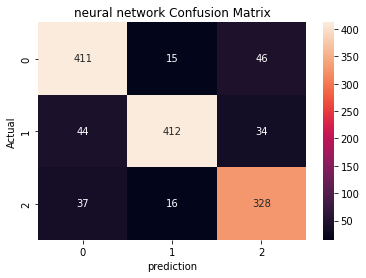

true
              precision    recall  f1-score   support

           0       0.84      0.87      0.85       472
           1       0.93      0.84      0.88       490
           2       0.80      0.86      0.83       381

    accuracy                           0.86      1343
   macro avg       0.86      0.86      0.86      1343
weighted avg       0.86      0.86      0.86      1343



In [35]:
get_accuracy_NN("neural network",model,x_train,y_train,x_test,y_test,y_train_enc,y_test_enc)

# ***model 2 neural ntework***

In [36]:

model=Sequential()
model.add(Dense( 120,input_shape=(100,),activation='relu' ))

model.add(Dense(64, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))


model.compile(optimizer = 'adam' ,loss = 'categorical_crossentropy' ,metrics=['accuracy'])



Epoch 1/50
257/257 [==============================] - 2s 4ms/step - loss: 0.5430 - accuracy: 0.7890
Epoch 2/50
257/257 [==============================] - 1s 4ms/step - loss: 0.4388 - accuracy: 0.8360
Epoch 3/50
257/257 [==============================] - 1s 4ms/step - loss: 0.4203 - accuracy: 0.8414
Epoch 4/50
257/257 [==============================] - 1s 4ms/step - loss: 0.4112 - accuracy: 0.8437
Epoch 5/50
257/257 [==============================] - 1s 4ms/step - loss: 0.4052 - accuracy: 0.8456
Epoch 6/50
257/257 [==============================] - 1s 4ms/step - loss: 0.4001 - accuracy: 0.8476
Epoch 7/50
257/257 [==============================] - 1s 5ms/step - loss: 0.3942 - accuracy: 0.8497
Epoch 8/50
257/257 [==============================] - 2s 7ms/step - loss: 0.3902 - accuracy: 0.8501
Epoch 9/50
257/257 [==============================] - 1s 5ms/step - loss: 0.3892 - accuracy: 0.8521
Epoch 10/50
257/257 [==============================] - 1s 4ms/step - loss: 0.3842 - accuracy: 0.8540

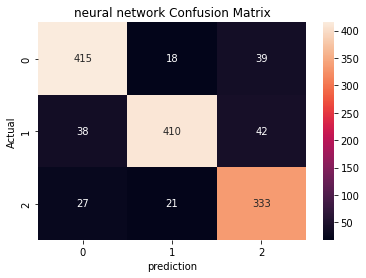

true
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       472
           1       0.91      0.84      0.87       490
           2       0.80      0.87      0.84       381

    accuracy                           0.86      1343
   macro avg       0.86      0.86      0.86      1343
weighted avg       0.87      0.86      0.86      1343



In [37]:
model.fit(x_train,y_train_enc,batch_size=256 ,epochs=50)
get_accuracy_NN("neural network",model,x_train,y_train,x_test,y_test,y_train_enc,y_test_enc)

CNN

In [38]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten
# Instantiate your model as usual
model = Sequential()
model.add(Conv2D(
                 filters=64,  
                 kernel_size=2,              
                 input_shape=(10,10,1),     
                 activation='relu')
)

model.add(Conv2D(8, kernel_size=3, activation='relu'))
model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(16, activation='relu'))
# End this multiclass model with 3 outputs and softmax
model.add(Dense(3, activation='softmax'))

model.summary ()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 64)          320       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           4616      
                                                                 
 flatten (Flatten)           (None, 392)               0         
                                                                 
 dense_9 (Dense)             (None, 64)                25152     
                                                                 
 dense_10 (Dense)            (None, 16)                1040      
                                                                 
 dense_11 (Dense)            (None, 3)                 51        
                                                                 
Total params: 31,179
Trainable params: 31,179
Non-trai

In [39]:
model.compile(optimizer = 'adam' ,loss = 'categorical_crossentropy' ,metrics=['accuracy'])
model.fit(x_train.reshape(-1,10,10,1),y_train_enc,batch_size=256 ,epochs=7)

Epoch 1/7
257/257 [==============================] - 15s 56ms/step - loss: 0.5563 - accuracy: 0.7920
Epoch 2/7
257/257 [==============================] - 14s 55ms/step - loss: 0.4581 - accuracy: 0.8296
Epoch 3/7
257/257 [==============================] - 16s 62ms/step - loss: 0.4386 - accuracy: 0.8347
Epoch 4/7
257/257 [==============================] - 20s 79ms/step - loss: 0.4287 - accuracy: 0.8367
Epoch 5/7
257/257 [==============================] - 19s 74ms/step - loss: 0.4197 - accuracy: 0.8403
Epoch 6/7
257/257 [==============================] - 14s 56ms/step - loss: 0.4152 - accuracy: 0.8425
Epoch 7/7
257/257 [==============================] - 18s 69ms/step - loss: 0.4096 - accuracy: 0.8443


In [40]:

pred=model.predict(x_test.reshape(-1,10,10,1))
pred_list=[]
for i in pred:
  pred_list.append(np.argmax(i))
from sklearn.metrics import accuracy_score
print("test accuracy : ", accuracy_score(y_test,pred_list)*100)
print("_______________________")
print(classification_report(y_test,pred_list  ))
print("confusion  matrix")
print(confusion_matrix(pred_list, y_test))

42/42 [==============================] - 0s 3ms/step
test accuracy :  84.36336559940432
_______________________
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       472
           1       0.96      0.80      0.87       490
           2       0.75      0.89      0.81       381

    accuracy                           0.84      1343
   macro avg       0.85      0.85      0.84      1343
weighted avg       0.86      0.84      0.85      1343

confusion  matrix
[[402  48  33]
 [  8 392   9]
 [ 62  50 339]]


rnn

In [41]:
import tensorflow as tf 
from tensorflow.keras.layers import Dense , SimpleRNN, Flatten ,Dropout, Input, Activation

In [42]:
input_shape = ( 100,1)
batch_size = 100
units = 256
dropout = 0.2

In [43]:
model = Sequential()
model.add(SimpleRNN(units=units,
                    dropout=dropout,
                    input_shape=input_shape))
model.add(Dense(3))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 256)               66048     
                                                                 
 dense_12 (Dense)            (None, 3)                 771       
                                                                 
 activation (Activation)     (None, 3)                 0         
                                                                 
Total params: 66,819
Trainable params: 66,819
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss=tf.keras.losses.CategoricalCrossentropy())
# train the network
model.fit(x_train, y_train_enc, epochs=2, batch_size=batch_size,)


Epoch 1/2
658/658 [==============================] - 118s 177ms/step - loss: 0.7211
Epoch 2/2
658/658 [==============================] - 113s 171ms/step - loss: 0.6426


# **GRU model**

In [45]:
model_gru= Sequential()
model_gru.add(Input(shape=(10,10)))
model_gru.add(GRU( 150,activation='relu'))

model_gru.add(Dense(3))
model_gru.add(Activation('softmax'))
model_gru.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 150)               72900     
                                                                 
 dense_13 (Dense)            (None, 3)                 453       
                                                                 
 activation_1 (Activation)   (None, 3)                 0         
                                                                 
Total params: 73,353
Trainable params: 73,353
Non-trainable params: 0
_________________________________________________________________


In [46]:
x_test=np.array(x_test).reshape(-1,10,10)
x_train=np.array(x_train).reshape(-1,10,10)

In [47]:
model_gru.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy()
              , metrics=['accuracy'])
model_gru.fit(x_train,y_train_enc,batch_size=64,epochs=20)

Epoch 1/20
1028/1028 [==============================] - 28s 25ms/step - loss: 0.5494 - accuracy: 0.7919
Epoch 2/20
1028/1028 [==============================] - 25s 24ms/step - loss: 0.4465 - accuracy: 0.8300
Epoch 3/20
1028/1028 [==============================] - 25s 25ms/step - loss: 0.4289 - accuracy: 0.8377
Epoch 4/20
1028/1028 [==============================] - 25s 24ms/step - loss: 0.4190 - accuracy: 0.8400
Epoch 5/20
1028/1028 [==============================] - 25s 24ms/step - loss: 0.4102 - accuracy: 0.8426
Epoch 6/20
1028/1028 [==============================] - 25s 24ms/step - loss: 0.4059 - accuracy: 0.8452
Epoch 7/20
1028/1028 [==============================] - 25s 24ms/step - loss: 0.4004 - accuracy: 0.8471
Epoch 8/20
1028/1028 [==============================] - 25s 24ms/step - loss: 0.3940 - accuracy: 0.8492
Epoch 9/20
1028/1028 [==============================] - 25s 24ms/step - loss: 0.3899 - accuracy: 0.8500
Epoch 10/20
1028/1028 [==============================] - 25s 25m

42/42 [==============================] - 1s 7ms/step - loss: 0.3735 - accuracy: 0.8615
test loss : 0.3735315501689911
test accuracy: 86.1504077911377
____________________________
2056/2056 [==============================] - 14s 7ms/step - loss: 0.3349 - accuracy: 0.8711
trainig loss : 0.3349282443523407
trainig accuracy: 87.10589408874512
____________________________
42/42 [==============================] - 0s 6ms/step


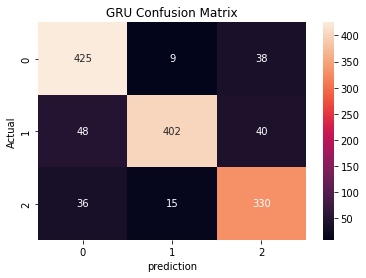

true
              precision    recall  f1-score   support

           0       0.83      0.90      0.87       472
           1       0.94      0.82      0.88       490
           2       0.81      0.87      0.84       381

    accuracy                           0.86      1343
   macro avg       0.86      0.86      0.86      1343
weighted avg       0.87      0.86      0.86      1343



In [48]:
loss,acc=model_gru.evaluate(x_test,y_test_enc)
print("test loss :", loss)
print('test accuracy:',acc*100)
print("____________________________")
loss,acc=model_gru.evaluate(x_train,y_train_enc)
print("trainig loss :", loss)
print('trainig accuracy:',acc*100)
print("____________________________")

pred=model_gru.predict(x_test)
pred_list=[]
for i in pred:
  pred_list.append(np.argmax(i))
cf1 = confusion_matrix(y_test,pred_list)
sns.heatmap(cf1,annot=True,fmt = '.0f')
plt.xlabel('prediction')
plt.ylabel('Actual')
plt.title("GRU"+ ' Confusion Matrix')
plt.show()
print("true")
print(classification_report(y_test,pred_list  ))

# **LSTM**

In [49]:
model_lstm= Sequential()
model_lstm.add(Input(shape=(10,10)))
model_lstm.add(LSTM(120  ,activation='relu'))
model_lstm.add(Dense(3))
model_lstm.add(Activation('softmax'))
model_lstm.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120)               62880     
                                                                 
 dense_14 (Dense)            (None, 3)                 363       
                                                                 
 activation_2 (Activation)   (None, 3)                 0         
                                                                 
Total params: 63,243
Trainable params: 63,243
Non-trainable params: 0
_________________________________________________________________


In [50]:
model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy()
              , metrics=['accuracy'])


In [51]:
model_lstm.fit(x_train,y_train_enc,batch_size=64,epochs=10)

Epoch 1/10
1028/1028 [==============================] - 24s 21ms/step - loss: 0.5617 - accuracy: 0.7847
Epoch 2/10
1028/1028 [==============================] - 29s 28ms/step - loss: 0.4565 - accuracy: 0.8262
Epoch 3/10
1028/1028 [==============================] - 46s 45ms/step - loss: 0.4406 - accuracy: 0.8313
Epoch 4/10
1028/1028 [==============================] - 38s 37ms/step - loss: 0.4313 - accuracy: 0.8360
Epoch 5/10
1028/1028 [==============================] - 22s 21ms/step - loss: 0.4254 - accuracy: 0.8362
Epoch 6/10
1028/1028 [==============================] - 22s 22ms/step - loss: 0.4189 - accuracy: 0.8388
Epoch 7/10
1028/1028 [==============================] - 23s 22ms/step - loss: 0.4131 - accuracy: 0.8403
Epoch 8/10
1028/1028 [==============================] - 23s 22ms/step - loss: 0.4083 - accuracy: 0.8439
Epoch 9/10
1028/1028 [==============================] - 22s 22ms/step - loss: 0.4052 - accuracy: 0.8435
Epoch 10/10
1028/1028 [==============================] - 23s 22m

42/42 [==============================] - 1s 6ms/step - loss: 0.4010 - accuracy: 0.8518
test loss : 0.4009794294834137
test accuracy: 85.18242835998535
____________________________
2056/2056 [==============================] - 14s 7ms/step - loss: 0.3969 - accuracy: 0.8481
trainig loss : 0.39689627289772034
trainig accuracy: 84.80891585350037
____________________________
42/42 [==============================] - 0s 6ms/step


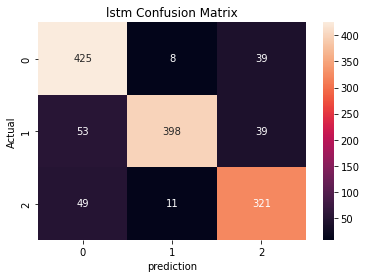

true
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       472
           1       0.95      0.81      0.88       490
           2       0.80      0.84      0.82       381

    accuracy                           0.85      1343
   macro avg       0.86      0.85      0.85      1343
weighted avg       0.86      0.85      0.85      1343



In [52]:
loss,acc=model_lstm.evaluate(x_test,y_test_enc)
print("test loss :", loss)
print('test accuracy:',acc*100)
print("____________________________")
loss,acc=model_lstm.evaluate(x_train,y_train_enc)
print("trainig loss :", loss)
print('trainig accuracy:',acc*100)
print("____________________________")

pred=model_lstm.predict(x_test)
pred_list=[]
for i in pred:
  pred_list.append(np.argmax(i))
cf1 = confusion_matrix(y_test,pred_list)
sns.heatmap(cf1,annot=True,fmt = '.0f')
plt.xlabel('prediction')
plt.ylabel('Actual')
plt.title("lstm"+ ' Confusion Matrix')
plt.show()
print("true")
print(classification_report(y_test,pred_list  ))

RNN model

In [53]:
model_RNN= Sequential()
model_RNN.add(Input(shape=(10,10)))
model_RNN.add(LSTM(120  ,activation='relu'))
model_RNN.add(Dense(3))
model_RNN.add(Activation('softmax'))
model_RNN.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 120)               62880     
                                                                 
 dense_15 (Dense)            (None, 3)                 363       
                                                                 
 activation_3 (Activation)   (None, 3)                 0         
                                                                 
Total params: 63,243
Trainable params: 63,243
Non-trainable params: 0
_________________________________________________________________


In [54]:
model_RNN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy()
              , metrics=['accuracy'])

In [56]:
model_RNN.fit(x_train,y_train_enc,batch_size=64,epochs=10)

Epoch 1/10
1028/1028 [==============================] - 38s 35ms/step - loss: 0.5593 - accuracy: 0.7830
Epoch 2/10
1028/1028 [==============================] - 39s 38ms/step - loss: 0.4573 - accuracy: 0.8260
Epoch 3/10
1028/1028 [==============================] - 23s 22ms/step - loss: 0.4423 - accuracy: 0.8319
Epoch 4/10
1028/1028 [==============================] - 23s 22ms/step - loss: 0.4333 - accuracy: 0.8354
Epoch 5/10
1028/1028 [==============================] - 23s 23ms/step - loss: 0.4266 - accuracy: 0.8367
Epoch 6/10
1028/1028 [==============================] - 22s 21ms/step - loss: 0.4213 - accuracy: 0.8383
Epoch 7/10
1028/1028 [==============================] - 24s 23ms/step - loss: 0.4159 - accuracy: 0.8400
Epoch 8/10
1028/1028 [==============================] - 23s 22ms/step - loss: 0.4106 - accuracy: 0.8424
Epoch 9/10
1028/1028 [==============================] - 22s 21ms/step - loss: 0.4064 - accuracy: 0.8443
Epoch 10/10
1028/1028 [==============================] - 23s 22m

42/42 [==============================] - 1s 6ms/step - loss: 0.3977 - accuracy: 0.8466
test loss : 0.39772137999534607
test accuracy: 84.661203622818
____________________________
2056/2056 [==============================] - 17s 8ms/step - loss: 0.3932 - accuracy: 0.8490
trainig loss : 0.3931567072868347
trainig accuracy: 84.90164279937744
____________________________
42/42 [==============================] - 1s 13ms/step


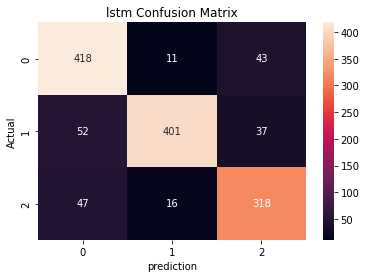

true
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       472
           1       0.94      0.82      0.87       490
           2       0.80      0.83      0.82       381

    accuracy                           0.85      1343
   macro avg       0.85      0.85      0.85      1343
weighted avg       0.85      0.85      0.85      1343



In [57]:
loss,acc=model_RNN.evaluate(x_test,y_test_enc)
print("test loss :", loss)
print('test accuracy:',acc*100)
print("____________________________")
loss,acc=model_RNN.evaluate(x_train,y_train_enc)
print("trainig loss :", loss)
print('trainig accuracy:',acc*100)
print("____________________________")

pred=model_RNN.predict(x_test)
pred_list=[]
for i in pred:
  pred_list.append(np.argmax(i))
cf1 = confusion_matrix(y_test,pred_list)
sns.heatmap(cf1,annot=True,fmt = '.0f')
plt.xlabel('prediction')
plt.ylabel('Actual')
plt.title("lstm"+ ' Confusion Matrix')
plt.show()
print("true")
print(classification_report(y_test,pred_list  ))